Fashion MNIST data set to be trained upon to experiment various optimization frameworks. We use a ConvNet to classify the images within the data.

We need to identify the order of importance for various hyperparameters. This can be done with a smaller dataset like Fashion MNIST for ConvNet and then get a fair estimate about the influence of various hyperparameters on the training. Once this influence is established, we can better the models on the actual data set using a series of frameworks and by utilizing the power of distributed computing on Ray framework.


In [3]:
!pip install scikit-optimize

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasClassifier

from skopt import dummy_minimize


from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize
from skopt.utils import use_named_args

In [5]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

def load_dataset():
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm   

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


We build a ConvNet model with Keras. We build a model by varying following Hyperparameters:
1. Learning rate
2. Number of convolutional layers
3. Number of dense nodes
4. Activation function
5. Regularization type
6. Dropout

In [4]:
from keras.layers import Dropout
def define_model(learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,activation,dropout,reg):
    model = Sequential()
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5,strides=1,filters=16,padding='same',activation=activation, kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes , activation=activation, kernel_initializer='he_uniform',kernel_regularizer=reg))
    model.add(Dropout(dropout))
        
    
    model.add(Dense(10, activation='softmax'))
    optimizer = Adam(lr=learning_rate)
    # compile model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
#Define the search space for hyperparameters
from skopt.space import Real, Categorical, Integer


dim_learning_rate = Real(low=1e-6, high=1e-2, prior = 'log-uniform', name = 'learning_rate')
dim_num_conv_layers=Integer(low=1, high=3, name='num_conv_layers')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=100, high=512, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu','LeakyReLU'],name='activation')
dim_dropout = Real(low=0.1, high=0.4, prior = 'log-uniform', name = 'dropout')
dim_regularization = Categorical(categories=['l1','l2','l1_l2'],name='reg')

In [6]:
param_grid = [dim_learning_rate,dim_num_conv_layers, dim_num_dense_layers,dim_num_dense_nodes,dim_activation,dim_dropout,dim_regularization]

In [7]:
path_best_model = 'define_model.h5'
best_accuracy = 0

In [8]:
@use_named_args(param_grid)
def objective(learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,activation,dropout,reg):
    
    
    print('learning rate: {0:0.1e}'.format(learning_rate))
    print('Number of convolutional layers ',num_conv_layers)
    print('num_dense_layers',num_dense_layers)
    print('num_dense_nodes',num_dense_nodes)
    print('activation',activation)
    print('dropout',dropout)
    print(' regularization used is ',reg)

    
    model = define_model(learning_rate=learning_rate,
                         num_conv_layers=num_conv_layers,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         dropout=dropout,
                         reg = reg)
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience =2, verbose =1, factor = 0.5, min_lr= 0.0001)
    
    history = model.fit(trainX,trainy,epochs=5,batch_size = 32,validation_split = 0.1, callbacks = learning_rate_reduction)
    
    accuracy = history.history['val_accuracy'][-1]
    
    print()
    print('accuracy is ', accuracy)
    print()
    
    global best_accuracy
    
    if accuracy>best_accuracy:
        model.save(path_best_model)
        
        best_accuracy=accuracy
        
    del model
    
    return -accuracy

In [6]:
#TEST RUN

trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)



In [10]:
default_parameters = [1e-5,1,1,100,'relu',0.2,'l1']

objective(default_parameters)

learning rate: 1.0e-05
Number of convolutional layers  1
num_dense_layers 1
num_dense_nodes 100
activation relu
dropout 0.2
 regularization used is  l1
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1688/1688 [==============================] - 39s 23ms/step - loss: 49.9946 - accuracy: 0.5291 - val_loss: 31.9076 - val_accuracy: 0.6840 - lr: 1.0000e-05
Epoch 2/5
1688/1688 [==============================] - 37s 22ms/step - loss: 19.6473 - accuracy: 0.6614 - val_loss: 9.9841 - val_accuracy: 0.7273 - lr: 1.0000e-05
Epoch 3/5
1688/1688 [==============================] - 37s 22ms/step - loss: 5.9047 - accuracy: 0.6835 - val_loss: 3.7128 - val_accuracy: 0.7283 - lr: 1.0000e-05
Epoch 4/5
1688/1688 [==============================] - 37s 22ms/step - loss: 3.0963 - accuracy: 0.6799 - val_loss: 2.5149 - val_accuracy: 0.7215 - lr: 1.0000e-05
Epoch 5/5
1688/1688 [==============================] - 38s 22ms/step - loss: 2.2981 - accuracy: 0.6803 - val_loss: 1.9864 - val_accuracy: 0.7355 - lr: 1.0000e-05

accuracy is  0.7354999780654907



-0.7354999780654907

In [14]:
default_parameters = [1e-5,1,1,100,'relu',0.2,'l1']

from skopt import forest_minimize, gbrt_minimize

fm= forest_minimize(
    objective,
    param_grid,
    x0=default_parameters,
    acq_func='EI',
    n_calls= 11,
    random_state = 0
)

#increase the number of call (n_calls) to reach much higher accuracy. The number has been kept low to demonstrate algoroithm

learning rate: 1.0e-05
Number of convolutional layers  1
num_dense_layers 1
num_dense_nodes 100
activation relu
dropout 0.2
 regularization used is  l1
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1688/1688 [==============================] - 38s 22ms/step - loss: 49.7364 - accuracy: 0.5521 - val_loss: 31.6112 - val_accuracy: 0.7247 - lr: 1.0000e-05
Epoch 2/5
1688/1688 [==============================] - 37s 22ms/step - loss: 19.2932 - accuracy: 0.6834 - val_loss: 9.6010 - val_accuracy: 0.7477 - lr: 1.0000e-05
Epoch 3/5
1688/1688 [==============================] - 40s 24ms/step - loss: 5.4983 - accuracy: 0.6914 - val_loss: 3.3689 - val_accuracy: 0.7307 - lr: 1.0000e-05
Epoch 4/5
1688/1688 [==============================] - 38s 23ms/step - loss: 2.8451 - accuracy: 0.6836 - val_loss: 2.3532 - val_accuracy: 0.7287 - lr: 1.0000e-05
Epoch 5/5
1688/1688 [==============================] - 37s 22ms/step - loss: 2.1742 - accuracy: 0.6810 - val_loss: 1.9086 - val_accuracy: 0.7233 - lr: 1.0000e-05

accuracy is  0.7233333587646484

learning rate: 2.4e-04
Number of convolutional layers  1
num_dense_layers 4
num_dense_nodes 351
activation LeakyReLU
dropout 0.17991426743025715
 regularization us

In [15]:
fm.x

[0.0002954894558726686, 3, 1, 344, 'relu', 0.34947686431875397, 'l2']

In [16]:
from skopt.plots import plot_convergence
from skopt.plots import plot_objective,plot_evaluations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb608fdad50>,
      dtype=object)

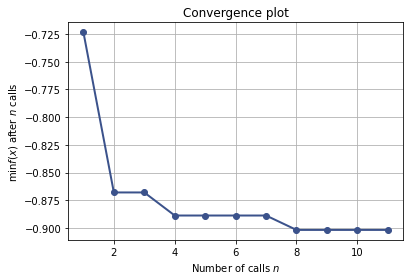

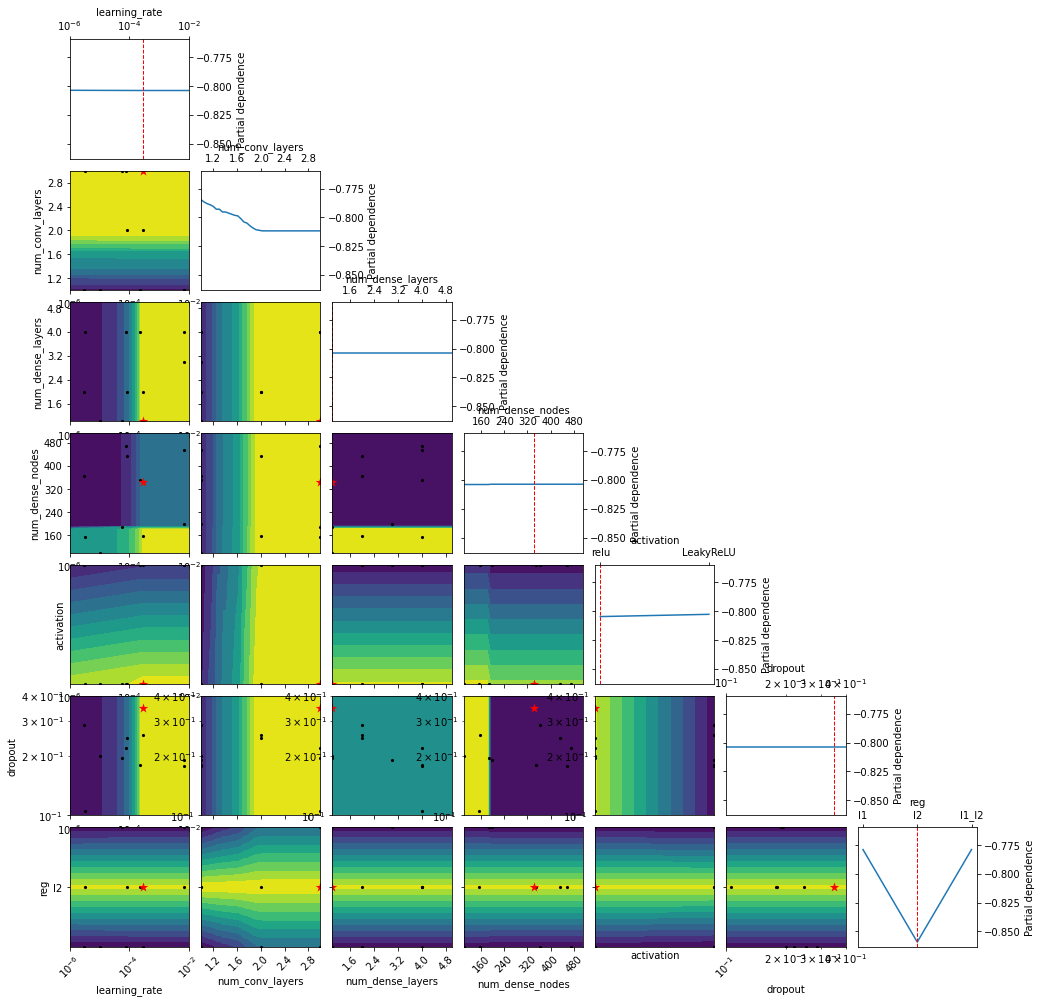

In [17]:
plot_convergence(fm)

plot_objective(fm)

**Followiing** hyperparameters dont have much impact on the performance:
1. number of dense nodes
2. number of dense layers
3. Relu and Leaky Relu doesnt make much difference

In [1]:
!pip install optuna

In [2]:
!pip install mlflow

In [7]:
import optuna
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

In [15]:

def objective(trial):

  with mlflow.start_run()as run:
    model=Sequential()

  #CONVOLUTIONAL LAYER

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  
  #MAX POOLING LAYER
    model.add(MaxPooling2D((2, 2)))

  #FLATTENING THE OUTPUT

    model.add(Flatten())

  # DEFINE A SEARCH SPACE FOR REGULARIZER

    regularizer_type = trial.suggest_categorical('regularizer_type',['l1','l2','l1_l2'])

    mlflow.log_param("regularizer_type", regularizer_type)


    if regularizer_type == 'l1':
      regularizer = regularizers.l1(l1=trial.suggest_loguniform('weight',0.001,0.1))
      

    if regularizer_type =='l2':
      regularizer = regularizers.l2(l2=trial.suggest_loguniform('weight',0.001,0.1))
      

    if regularizer_type =='l1_l2':
      regularizer = regularizers.l1_l2(l1=trial.suggest_loguniform('weight1',0.001,0.1),l2=trial.suggest_loguniform('weight2',0.001,0.1))
      
    
 #DENSE LAYERS
    model.add(Dense(188, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=regularizer))
    model.add(Dense(10, activation='softmax'))


  #VARYING THE OPTIMIZER

    optimizer_name = trial.suggest_categorical('optimizer_name',['Adam','RMSprop'])

    mlflow.log_param("optimizer_name", optimizer_name)


    if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate = trial.suggest_float('learning_rate',0.00001,0.0001))

    if optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate= trial.suggest_float('learning_rate',0.00001,0.0001),momentum=trial.suggest_float('momentum',0.6,0.95))

  #COMPILE THE MODEL
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    #VARY THE BATCH SIZE

    batch_size = trial.suggest_categorical('batch_size',[32,64,128])
    mlflow.log_param("batch_size", batch_size)


  #FIT THE MODEL

    history= model.fit(
        trainX,
        trainY,
        batch_size=batch_size,
        epochs=5,
        verbose=1,
        validation_data=(testX, testY))
    
    
  
    accuracy = history.history['val_accuracy'][-1]

    mlflow.log_metric("accuracy",accuracy)
  
    print('accuracy is ', accuracy)
  
    global best_accuracy
  
    del model

    

    return accuracy

In [13]:
#note that mlflow may run into trouble when working with google colab. but this can be run in jupyter

from optuna.integration.mlflow import MLflowCallback
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment_name = "hpo"
try:
    experiment = client.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name).experiment_id
study_run = client.create_run(experiment_id=experiment)
study_run_id = study_run.info.run_id



if __name__ == "__main__":
  mlflc = MLflowCallback(tracking_uri='ml_exp1',metric_name='accuracy')
  study= optuna.create_study(
    direction='maximize',
    study_name='cnn_study',
    load_if_exists=True)
  study.optimize(objective, n_trials=30, callbacks=[mlflc])

TypeError: ignored

Optuna has good visualization tools too! 
We can plot the relative importance between the hyperparameters we tried to tune using below code

In [ ]:
optuna.visualization.plot_param_importances

Ray Tune is a library that enables distributed computing. Using this for extreme large number of epochs can be significantly useful.

However it is recommended that raytune is particularly used for Random Search, population based training and Tree Parzen Estimator algorithms as these are efficient to e run in parallel.

In [17]:
!pip install ray[tune]

     |████████████████████████████████| 52.7 MB 1.7 MB/s 
     |████████████████████████████████| 175 kB 26.0 MB/s 
     |████████████████████████████████| 4.1 MB 44.6 MB/s 
     |████████████████████████████████| 125 kB 38.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [24]:
import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.integration.keras import TuneReportCallback


def train_mnist(config):
    # https://github.com/tensorflow/tensorflow/issues/32159
    import tensorflow as tf
    batch_size = 32
    num_classes = 10
    epochs = 10

    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()

    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)


     
    trainX, x_test = trainX / 255.0, testX / 255.0
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(units = config["hidden"] , activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=config["lr"], momentum=config["momentum"])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  

    model.fit(
        trainX,
        trainY,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(x_test, testY),
        callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])


the following run function enables us to choose the search algorithm.
See the documentation of raytune to see the list of algorithms

We can also choose the scheduler that helps in killing the bad performing models and continuing with high quality ones.

This can also be implemented with mlflow as shown with optuna.

In [ ]:
from ray.tune.suggest.optuna import OptunaSearch
import argparse
from argparse import ArgumentParser



def tune_mnist(num_training_iterations):
    sched = AsyncHyperBandScheduler(
        time_attr="training_iteration", max_t=400, grace_period=20)

    analysis = tune.run(
        train_mnist,
        name="exp",
        search_alg=OptunaSearch(),
        scheduler=sched,
        metric="mean_accuracy",
        mode="max",
        stop={
            "mean_accuracy": 0.99,
            "training_iteration": num_training_iterations
        },
        num_samples=15,
        resources_per_trial={
            "cpu": 2,
            "gpu": 0
        },
        config={
            "threads": 2,
            "lr": tune.uniform(0.000001,0.1),
            "momentum": tune.uniform(0.1, 0.9),
            "hidden": tune.randint(32, 512)
        })
    print("Best hyperparameters found were: ", analysis.best_config)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--smoke-test", action="store_true", help="Finish quickly for testing")
    parser.add_argument(
        "--server-address",
        type=str,
        default=None,
        required=False,
        help="The address of server to connect to if using "
        "Ray Client.")
    args, _ = parser.parse_known_args()
    if args.smoke_test:
        ray.init(num_cpus=4)
    elif args.server_address:
        ray.init(f"ray://{args.server_address}")

    tune_mnist(num_training_iterations=5 if args.smoke_test else 300)

[I 2022-03-22 22:38:21,535] A new study created in memory with name: optuna


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,PENDING,,472,0.0903284,0.857448


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


(train_mnist pid=3591) 2022-03-22 22:38:27.933913: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Trial name,status,loc,hidden,lr,momentum
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-39-37
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 1
  mean_accuracy: 0.8512166738510132
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 71.06414246559143
  time_this_iter_s: 71.06414246559143
  time_total_s: 71.06414246559143
  timestamp: 1647988777
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.851217,1,71.0641
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-40-46
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 2
  mean_accuracy: 0.8908833265304565
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 139.2930428981781
  time_this_iter_s: 68.22890043258667
  time_total_s: 139.2930428981781
  timestamp: 1647988846
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.890883,2,139.293
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-41-53
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 3
  mean_accuracy: 0.9067666530609131
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 207.1672236919403
  time_this_iter_s: 67.8741807937622
  time_total_s: 207.1672236919403
  timestamp: 1647988913
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.906767,3,207.167
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-43-02
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 4
  mean_accuracy: 0.918150007724762
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 276.05971097946167
  time_this_iter_s: 68.89248728752136
  time_total_s: 276.05971097946167
  timestamp: 1647988982
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.91815,4,276.06
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-44-11
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 5
  mean_accuracy: 0.9273999929428101
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 344.8652651309967
  time_this_iter_s: 68.80555415153503
  time_total_s: 344.8652651309967
  timestamp: 1647989051
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9274,5,344.865
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-45-20
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 6
  mean_accuracy: 0.937333345413208
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 414.2197506427765
  time_this_iter_s: 69.35448551177979
  time_total_s: 414.2197506427765
  timestamp: 1647989120
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.937333,6,414.22
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-46-30
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 7
  mean_accuracy: 0.9437000155448914
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 483.81143260002136
  time_this_iter_s: 69.59168195724487
  time_total_s: 483.81143260002136
  timestamp: 1647989190
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9437,7,483.811
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-47-41
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 8
  mean_accuracy: 0.9510833621025085
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 554.3993961811066
  time_this_iter_s: 70.5879635810852
  time_total_s: 554.3993961811066
  timestamp: 1647989261
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.951083,8,554.399
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-48-49
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 9
  mean_accuracy: 0.9559333324432373
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 623.0491650104523
  time_this_iter_s: 68.6497688293457
  time_total_s: 623.0491650104523
  timestamp: 1647989329
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.955933,9,623.049
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-49-58
  done: false
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  hostname: 77fbfcdd8e64
  iterations_since_restore: 10
  mean_accuracy: 0.960099995136261
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 691.6362838745117
  time_this_iter_s: 68.58711886405945
  time_total_s: 691.6362838745117
  timestamp: 1647989398
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c6fee446,RUNNING,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,


Result for train_mnist_c6fee446:
  date: 2022-03-22_22-49-58
  done: true
  experiment_id: 4c57b1c6c9474c56b52ee4c7a77d0893
  experiment_tag: 1_hidden=472,lr=0.090328,momentum=0.85745,threads=2
  hostname: 77fbfcdd8e64
  iterations_since_restore: 10
  mean_accuracy: 0.960099995136261
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 691.6362838745117
  time_this_iter_s: 68.58711886405945
  time_total_s: 691.6362838745117
  timestamp: 1647989398
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c6fee446
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,PENDING,,491,0.0581844,0.550695,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


(train_mnist pid=3902) 2022-03-22 22:51:00.375702: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,,,
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_22-52-16
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 1
  mean_accuracy: 0.857200026512146
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 77.36641073226929
  time_this_iter_s: 77.36641073226929
  time_total_s: 77.36641073226929
  timestamp: 1647989536
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.8572,1,77.3664
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_22-53-35
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 2
  mean_accuracy: 0.9008166790008545
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 155.4889190196991
  time_this_iter_s: 78.12250828742981
  time_total_s: 155.4889190196991
  timestamp: 1647989615
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.900817,2,155.489
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_22-54-50
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 3
  mean_accuracy: 0.9174000024795532
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 231.31282687187195
  time_this_iter_s: 75.82390785217285
  time_total_s: 231.31282687187195
  timestamp: 1647989690
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9174,3,231.313
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_22-56-06
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 4
  mean_accuracy: 0.9282333254814148
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 307.0503981113434
  time_this_iter_s: 75.73757123947144
  time_total_s: 307.0503981113434
  timestamp: 1647989766
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.928233,4,307.05
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_22-57-21
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 5
  mean_accuracy: 0.9376999735832214
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 382.25620102882385
  time_this_iter_s: 75.20580291748047
  time_total_s: 382.25620102882385
  timestamp: 1647989841
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.9377,5,382.256
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_22-58-37
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 6
  mean_accuracy: 0.9468500018119812
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 457.7016849517822
  time_this_iter_s: 75.44548392295837
  time_total_s: 457.7016849517822
  timestamp: 1647989917
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.94685,6,457.702
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_22-59-53
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 7
  mean_accuracy: 0.9529833197593689
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 533.8011176586151
  time_this_iter_s: 76.09943270683289
  time_total_s: 533.8011176586151
  timestamp: 1647989993
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.952983,7,533.801
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_23-01-10
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 8
  mean_accuracy: 0.9590833187103271
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 611.0549228191376
  time_this_iter_s: 77.25380516052246
  time_total_s: 611.0549228191376
  timestamp: 1647990070
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.959083,8,611.055
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_23-02-26
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 9
  mean_accuracy: 0.9649666547775269
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 687.1551861763
  time_this_iter_s: 76.10026335716248
  time_total_s: 687.1551861763
  timestamp: 1647990146
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.964967,9,687.155
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_23-03-43
  done: false
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  hostname: 77fbfcdd8e64
  iterations_since_restore: 10
  mean_accuracy: 0.9713500142097473
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 763.8399481773376
  time_this_iter_s: 76.6847620010376
  time_total_s: 763.8399481773376
  timestamp: 1647990223
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_c7fb4308,RUNNING,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84
train_mnist_888d6118,PENDING,,199,0.000941605,0.672035,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636


Result for train_mnist_c7fb4308:
  date: 2022-03-22_23-03-43
  done: true
  experiment_id: ba5cbb707b8748b9a9710d3f99cea458
  experiment_tag: 2_hidden=491,lr=0.058184,momentum=0.55069,threads=2
  hostname: 77fbfcdd8e64
  iterations_since_restore: 10
  mean_accuracy: 0.9713500142097473
  node_ip: 172.28.0.2
  pid: 3902
  time_since_restore: 763.8399481773376
  time_this_iter_s: 76.6847620010376
  time_total_s: 763.8399481773376
  timestamp: 1647990223
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c7fb4308
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


(train_mnist pid=4255) 2022-03-22 23:04:32.013853: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,,,
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Result for train_mnist_888d6118:
  date: 2022-03-22_23-05-22
  done: false
  experiment_id: 51abe99c5bb64fcd8b792cd232e14cd4
  hostname: 77fbfcdd8e64
  iterations_since_restore: 1
  mean_accuracy: 0.7967666387557983
  node_ip: 172.28.0.2
  pid: 4255
  time_since_restore: 51.39799880981445
  time_this_iter_s: 51.39799880981445
  time_total_s: 51.39799880981445
  timestamp: 1647990322
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 888d6118
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.796767,1,51.398
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Result for train_mnist_888d6118:
  date: 2022-03-22_23-06-11
  done: false
  experiment_id: 51abe99c5bb64fcd8b792cd232e14cd4
  hostname: 77fbfcdd8e64
  iterations_since_restore: 2
  mean_accuracy: 0.8479166626930237
  node_ip: 172.28.0.2
  pid: 4255
  time_since_restore: 100.28085803985596
  time_this_iter_s: 48.882859230041504
  time_total_s: 100.28085803985596
  timestamp: 1647990371
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 888d6118
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
train_mnist_888d6118,RUNNING,172.28.0.2:4255,199,0.000941605,0.672035,0.847917,2,100.281
train_mnist_6c6c1c20,PENDING,,479,0.0933198,0.331666,,,
train_mnist_c6fee446,TERMINATED,172.28.0.2:3591,472,0.0903284,0.857448,0.9601,10,691.636
train_mnist_c7fb4308,TERMINATED,172.28.0.2:3902,491,0.0581844,0.550695,0.97135,10,763.84


Once the optimal learning parameters are identified, the network architecture can be optimized by using Population based training / Hyperband search algorithms. these algorithms perform extremely well with Ray tune desitributed computing. The only change that needs to be done is to import the necessary library and replace the search_alg in tune.run function